<a href="https://colab.research.google.com/github/rishavsen1/A_star/blob/main/pytorch_part1_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.12.1+cu113'

In [ ]:
# create known parameters
#(equivalent to y=ax+b) (a is weight, b is bias)
weight = 0.7
bias = 0.3 

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias

X[:10], y[:10]
# , X.shape, y.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

## splitting data into training and testing data

In [ ]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
  plt.scatter(test_data, test_labels, c='g', s=4, label='Test data')
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  plt.legend(prop={"size":14})  

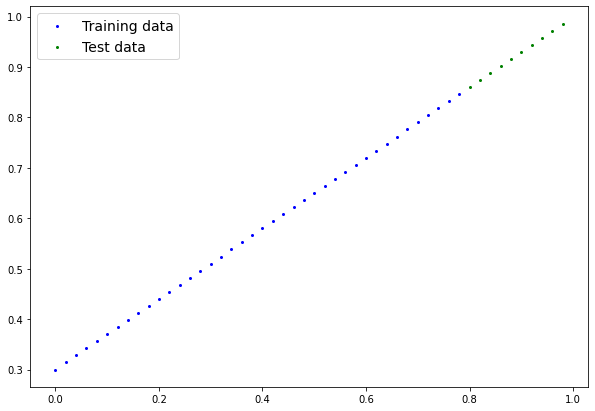

In [ ]:
plot_predictions()

# first pytorch model

In [ ]:
# linear reg model class
from torch import nn

class linearRegressionModel(nn.Module): #almost everything in pytorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True, 
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, 
                                         requires_grad=True, 
                                         dtype=torch.float))
  
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias # linear reg formula

In [ ]:
torch.manual_seed(42)

model_0 = linearRegressionModel()

#checking out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
#list of model parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## making infereence using `torch.inference_mode()`

In [ ]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]), tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [ ]:
y_preds = model_0(X_test) # keeps gradient tracking on
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [ ]:
# make predcitions with model

with torch.inference_mode(): #turns off gradient tracking
  y_preds = model_0(X_test)

with torch.no_grad(): #similar to inference_mode(), however inference_mode() is preferred(https://twitter.com/pytorch/status/1437838231505096708?lang=en)
  y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

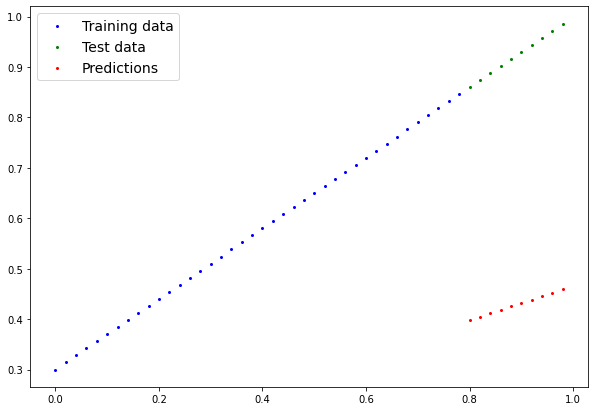

In [ ]:
plot_predictions(predictions=y_preds)

##Building training loop

Needed:
0. Loop through the data
2. Forward pass (involves data moving through `forward()` method) to make predictions on data
3. Calculate loss (compare foward pass predictions to ground truth labels)
4. Optimizer zero grad
5. Loss backward - moves backward through the network to calculate the gradients of each parameter of our model wrt loss  (**backpropagation**)
6. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# epoch is one loop through the data; it is a hyperparameter, since we set it
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR

torch.manual_seed(42)
# model_0 = linearRegressionModel()
# setup loss function
loss_fn = nn.L1Loss()

# setup optimizer
#read torch.autograd()

optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

# scheduler1 = ExponentialLR(optimizer, gamma=0.9)
# scheduler1 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.05)
epochs = 200

epoch_count = []
train_loss_values = []
test_loss_values = []

## Training
# 0. Loop through the data
for epoch in range(epochs):
  #set model to training mode  
  model_0.train() # train mode sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train) #loss(input, target)
  # print(f"Loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (peform backpropagation wrt parameters of the model)
  loss.backward()

  #5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default, the optimizer changes will accumulate through the loop, so we have to zero it in every loop (step 3)

  #Testing
  model_0.eval()#turns off gradient tracking
  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch%10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.3013603389263153 | Test loss: 0.4675942063331604
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
Epoch: 10 | Loss: 0.18615034222602844 | Test loss: 0.3328842222690582
OrderedDict([('weights', tensor([0.3835])), ('bias', tensor([0.2488]))])
Epoch: 20 | Loss: 0.08227583020925522 | Test loss: 0.2069590985774994
OrderedDict([('weights', tensor([0.4222])), ('bias', tensor([0.3403]))])
Epoch: 30 | Loss: 0.05181945487856865 | Test loss: 0.14023718237876892
OrderedDict([('weights', tensor([0.4539])), ('bias', tensor([0.3788]))])
Epoch: 40 | Loss: 0.04503796249628067 | Test loss: 0.11182951927185059
OrderedDict([('weights', tensor([0.4768])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04132963344454765 | Test loss: 0.09809747338294983
OrderedDict([('weights', tensor([0.4956])), ('bias', tensor([0.3838]))])
Epoch: 60 | Loss: 0.03785243630409241 | Test loss: 0.08776430785655975
OrderedDict([('weights', tensor([0.5134])), ('bias', tensor([0.3783]))

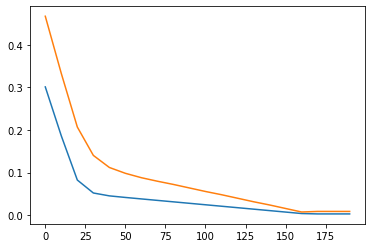

In [ ]:
plt.plot(epoch_count, train_loss_values, label='Train_loss')
plt.plot(epoch_count, test_loss_values, label='Train_loss')

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

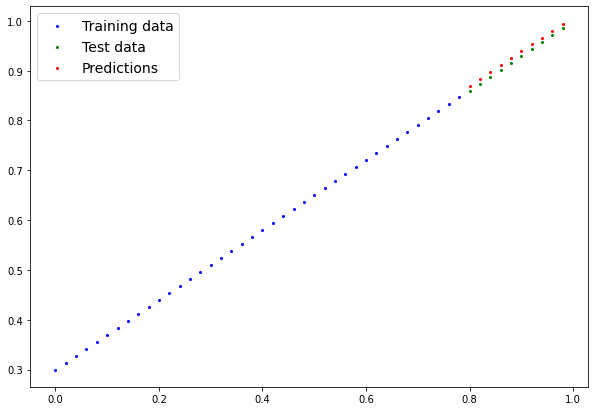

In [ ]:
plot_predictions(predictions=y_preds_new)

In [ ]:
weight, bias

(0.7, 0.3)

## Saving/Loading pytorch models
1. `torch.save()` (saves in pickle format)
2. `torch.load()`
3. `torch.nn.Module.load_state_dict()`

In [ ]:
from pathlib import Path

# 1. Create models dir
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pt'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict()
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1063 Aug 17 02:47 01_pytorch_workflow_model_0.pt


In [ ]:
# Loading model's state_dict()
# To load in a saved state_dict(), we have to instantiate a new instance of our model class

loaded_model_0 = linearRegressionModel()
# loaded_model_0.state_dict()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])